In [1]:
# -----INSTALLS-----

# %pip install tensorflow

In [2]:
##### -----IMPORTS-----

import joblib      # to load saved dataframes, scalers and models or save new
import pandas as pd     # for dataframe operations
import numpy as np     # for numpy array while creating sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential    # to create sequential model
from tensorflow.keras.layers import LSTM, Input, TimeDistributed, Dense     # layer architectures in model
from tensorflow.keras.optimizers import Adam     # optimizer used
from tensorflow.keras.models import load_model     # to load saved model
from tensorflow.keras.backend import clear_session       # to clean the memory used in cross validation
from tensorflow.keras.callbacks import EarlyStopping       # to stop the training early for best generalization
from tensorflow.keras.metrics import RootMeanSquaredError      # to observe rsme stats of models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score       # for final evaluation
import random          # for random search hypertuning
from gc import collect       # to clear memory
import matplotlib.pyplot as plt      # to plot final prediction to actual target

C:\Users\rutuj\AppData\Roaming\Python\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
train_df = joblib.load('../saved_objects/train_df.joblib')     # train data
temp_df = joblib.load('../saved_objects/temp_df.joblib')     # dataframe to split into val and test

Both of the above dataset are scaled and encoded

## Final Feature Set

In [4]:
temp_df.columns

Index(['home_id', 'device_type', 'timestamp', 'user_present', 'status',
       'is_weekend', 'hour_of_day', 'day_of_week', 'month_of_year',
       'indoor_temp', 'outdoor_temp', 'humidity', 'light_level',
       'device_type_air_conditioner', 'device_type_fridge',
       'device_type_light', 'device_type_tv', 'device_type_washer',
       'room_bedroom', 'room_kitchen', 'room_laundry_room', 'room_living_room',
       'activity_away', 'activity_cooking', 'activity_idle',
       'activity_sleeping', 'activity_watching_tv', 'energy_lag_1H',
       'energy_lag_1D', 'energy_lag_1W', 'energy_roll_mean_1hr',
       'energy_roll_mean_12hr', 'energy_roll_mean_24hr', 'energy_kWh'],
      dtype='object')

In [5]:
temp_df = temp_df.sort_values(['device_type', 'home_id', 'timestamp'])
train_df = train_df.sort_values(['device_type', 'home_id', 'timestamp'])

train_df.head(100000)[['home_id', 'device_type']].value_counts()

home_id  device_type    
1        air_conditioner    24057
2        air_conditioner    24057
3        air_conditioner    24057
4        air_conditioner    24057
5        air_conditioner     3772
Name: count, dtype: int64

`home_id, device_type, timestamp` are metadata used to group the data in a sequence but won't be feeded into model

## Splitting `temp_df` in val and test set

In [6]:
val_rec = []      # stores record belonging to validation set
test_rec = []       # stores record belonging to test set

for _, group in temp_df.groupby(['device_type', 'home_id']):       # each set (train, test, val) must have ordered, sequential and balanced data
    n = len(group)
    split = int(n / 2)     # temp_df -> 0.5 test + 0.5 val OR overall_df -> 0.3 * 0.5 = 0.15

    val_rec.append(group.iloc[:split])
    test_rec.append(group.iloc[split:])

# convert the records to dataframe
val_df = pd.concat(val_rec)
test_df = pd.concat(test_rec)


print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1202850, 34)
(257750, 34)
(257800, 34)


In [7]:
DROP_COLS = ['home_id', 'device_type', 'timestamp']
NON_IN = ['energy_kWh']

feature_order = [c for c in train_df.columns if c not in (DROP_COLS+NON_IN)]
joblib.dump(feature_order, '../saved_objects/feature_order.joblib')
feature_order

['user_present',
 'status',
 'is_weekend',
 'hour_of_day',
 'day_of_week',
 'month_of_year',
 'indoor_temp',
 'outdoor_temp',
 'humidity',
 'light_level',
 'device_type_air_conditioner',
 'device_type_fridge',
 'device_type_light',
 'device_type_tv',
 'device_type_washer',
 'room_bedroom',
 'room_kitchen',
 'room_laundry_room',
 'room_living_room',
 'activity_away',
 'activity_cooking',
 'activity_idle',
 'activity_sleeping',
 'activity_watching_tv',
 'energy_lag_1H',
 'energy_lag_1D',
 'energy_lag_1W',
 'energy_roll_mean_1hr',
 'energy_roll_mean_12hr',
 'energy_roll_mean_24hr']

### LSTM expects 3D input: (samples, timesteps, features)

In [8]:
SEQ_LEN = 12     # sequence length = records in a sequence (12 * 1/4 so 3 hours)

def create_sequences(df, seq_len, target_col):
    X, y = [], []

    feature_cols = [c for c in df.columns if c not in DROP_COLS + [target_col]]

    for _, group in df.groupby(['home_id', 'device_type']):
        group = group.sort_values('timestamp')

        data = group[feature_cols].values
        target = group[target_col].values

        for i in range(seq_len, len(group)):
            X.append(data[i-seq_len:i])
            y.append(target[i-seq_len:i])

    return np.array(X, dtype = np.float32), np.array(y, dtype = np.float32)


X_train, y_train = create_sequences(train_df, SEQ_LEN, 'energy_kWh')
X_val,   y_val   = create_sequences(val_df,   SEQ_LEN, 'energy_kWh')
X_test,  y_test  = create_sequences(test_df,  SEQ_LEN, 'energy_kWh')

print("Train Shape: ", X_train.shape, ', ', y_train.shape)
print("Val Shape: ", X_val.shape, ', ', y_val.shape)
print("Test Shape: ", X_test.shape, ', ', y_test.shape)

Train Shape:  (1202250, 12, 30) ,  (1202250, 12)
Val Shape:  (257150, 12, 30) ,  (257150, 12)
Test Shape:  (257200, 12, 30) ,  (257200, 12)


In [9]:
FEATURE_LEN = X_train.shape[2]
FEATURE_LEN

30

## Input shape: (timesteps=12, features=30)
### train samples = 1202250
### val samples = 257150
### test samples = 257200

In [10]:
len(X_train[0])      # 1 sequence contains 3 * 4 = 12 records

12

In [11]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
X_train[0][:3]      
# sequence content (first three):

array([[1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        5.0000000e+00, 1.0000000e+00, 1.1219512e-01, 4.3126684e-02,
        9.0825689e-01, 8.2800001e-02, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.8031999e-01, 0.0000000e+00, 0.0000000e+00,
        7.7801039e-03, 7.5626303e-03],
       [1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        5.0000000e+00, 1.0000000e+00, 1.0243902e-01, 1.6172506e-02,
        7.6933157e-01, 6.1000001e-02, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        7

In [13]:
type(X_train[0][0][0])

numpy.float32

### Custom Loss Function

In [14]:
@tf.keras.utils.register_keras_serializable()
def asymmetric_huber(
    y_true,
    y_pred,
    delta=0.1,
    under_weight=2.25,
    over_weight=1.25
):
    error = y_pred - y_true
    abs_error = tf.abs(error)

    # Huber loss formulation
    huber = tf.where(
        abs_error <= delta,
        0.5 * tf.square(error),
        delta * (abs_error - 0.5 * delta)
    )

    weight = tf.where(error < 0, under_weight, over_weight)
    return tf.reduce_mean(weight * huber)

A custom loss function based on Huber loss that penalizes
**under-predictions more than over-predictions**.

This is useful for energy forecasting, where underestimating
future consumption can be more costly than overestimating.

### Model Architecture

In [15]:
Redesign = True

def build_lstm_model():
    
    model = Sequential([
        Input(shape = (SEQ_LEN, FEATURE_LEN)),
        LSTM(
            units = 128,
            return_sequences = True,
            dropout = 0.05,
            recurrent_dropout = 0.0
        ),
        LSTM(
            units = 64,
            return_sequences = True,
            dropout= 0.05,
            recurrent_dropout = 0.0
        ),
        TimeDistributed(
            Dense(
                units = 64,
                activation = "relu"
            )
        ),
        TimeDistributed(
            Dense(
                units = 32,
                activation = "relu"
            )
        ),
        TimeDistributed(
            Dense(
                units = 1,
                activation='linear'
            )
        )
    ])
    
    model.compile(
        optimizer=Adam(learning_rate = 0.001),
        loss=asymmetric_huber,
        metrics=[
            "mae",
            RootMeanSquaredError(name="rmse")
        ]
    )

    return model


A stacked LSTM architecture designed for sequence-to-sequence
energy forecasting.

- Stacked LSTMs capture both short- and mid-term temporal patterns
- Light dropout improves generalization without harming memory
- TimeDistributed dense layers learn per-timestep feature interactions
- Linear output allows unconstrained regression values
- Trained using an asymmetric Huber loss for robust, risk-aware learning

## Early Stopping for final model

In [16]:
if Redesign:
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )

    model_ = build_lstm_model()
    
    history = model_.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=20,          # upper bound
        batch_size=64,
        shuffle=False,
        callbacks=[early_stop],
        verbose=1
    )

    model_.save("../saved_objects/FinalModel.keras")
    
    final_metrics = {
        "final_val_mae": history.history["val_mae"][-1],
        "final_val_rmse": history.history["val_rmse"][-1]
    }
    
    joblib.dump(final_metrics, "../saved_objects/final_lstm_model_metrics.joblib")

    print()
    print("Final Metrics:")

else:
    model_ = load_model("../saved_objects/FinalModel.keras")
    final_metrics = joblib.load("../saved_objects/final_lstm_model_metrics.joblib")

    print("Loaded final model metrics:")

for k, v in final_metrics.items():
        print(f"{k}: {v}")

Epoch 1/20
18786/18786 ━━━━━━━━━━━━━━━━━━━━ 984s 51ms/step - loss: 2.9504e-04 - mae: 0.0073 - rmse: 0.0198 - val_loss: 5.6001e-04 - val_mae: 0.0127 - val_rmse: 0.0296
Epoch 2/20
18786/18786 ━━━━━━━━━━━━━━━━━━━━ 929s 49ms/step - loss: 7.8932e-05 - mae: 0.0034 - rmse: 0.0102 - val_loss: 1.3046e-04 - val_mae: 0.0061 - val_rmse: 0.0139
Epoch 3/20
18786/18786 ━━━━━━━━━━━━━━━━━━━━ 934s 50ms/step - loss: 6.7066e-05 - mae: 0.0028 - rmse: 0.0095 - val_loss: 7.0779e-05 - val_mae: 0.0039 - val_rmse: 0.0093
Epoch 4/20
18786/18786 ━━━━━━━━━━━━━━━━━━━━ 992s 53ms/step - loss: 6.1536e-05 - mae: 0.0025 - rmse: 0.0091 - val_loss: 1.0029e-04 - val_mae: 0.0049 - val_rmse: 0.0118
Epoch 5/20
18786/18786 ━━━━━━━━━━━━━━━━━━━━ 935s 50ms/step - loss: 6.0202e-05 - mae: 0.0024 - rmse: 0.0090 - val_loss: 1.0716e-04 - val_mae: 0.0053 - val_rmse: 0.0113
Epoch 6/20
18786/18786 ━━━━━━━━━━━━━━━━━━━━ 916s 46ms/step - loss: 5.8605e-05 - mae: 0.0023 - rmse: 0.0089 - val_loss: 7.7750e-05 - val_mae: 0.0045 - val_rmse: 0.009

In [17]:
threshold = 0.025
 
y_pred = model_.predict(X_test)
y_pred[y_pred < threshold] = 0.0

y_pred_ = y_pred.reshape(-1)
y_test_ = y_test.reshape(-1)

mae = mean_absolute_error(y_test_, y_pred_)
rmse = np.sqrt(mean_squared_error(y_test_, y_pred_))
r2 = r2_score(y_test_, y_pred_)

print(f"Test MAE  : {mae:.5f}")
print(f"Test RMSE : {rmse:.5f}")
print(f"Test R²   : {r2:.4f}")

8038/8038 ━━━━━━━━━━━━━━━━━━━━ 106s 13ms/step
Test MAE  : 0.00336
Test RMSE : 0.00863
Test R²   : 0.9639


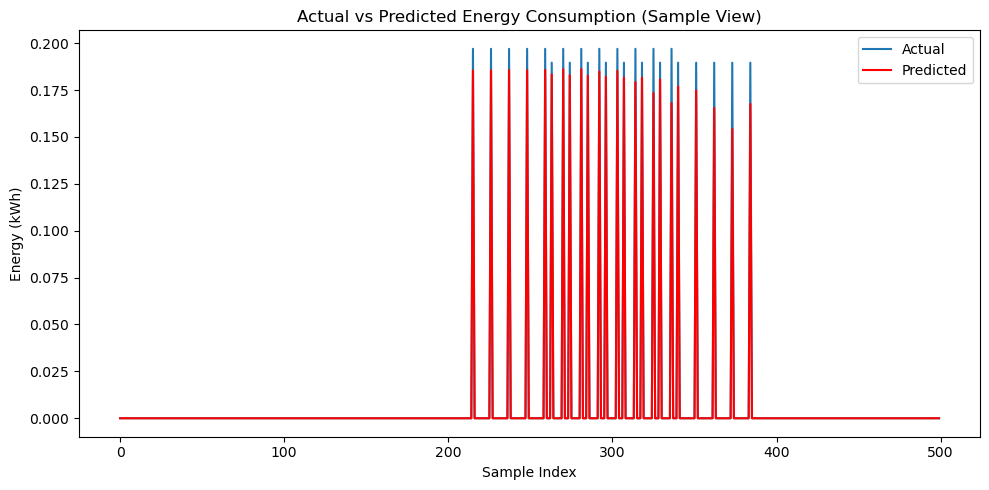

<Figure size 640x480 with 0 Axes>

In [18]:
sample_size = 500 # avoid clutter
plt.figure(figsize=(10, 5))
plt.plot(y_test_[:sample_size], label="Actual")
plt.plot(y_pred_[:sample_size], label="Predicted", color='red')
plt.xlabel("Sample Index")
plt.ylabel("Energy (kWh)")
plt.title("Actual vs Predicted Energy Consumption (Sample View)")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('../reports/Milestone3/predictedVSactual_lstm.png')

| Metric       | Linear Regression | LSTM       |
|-------------|-----------------|-----------|
| Test MAE    | <span style="color:red">0.016</span> | <span style="color:green">0.003</span> |
| Test RMSE   | <span style="color:red">0.025</span> | <span style="color:green">0.008</span> |
| Test R²     | <span style="color:red">0.70</span> | <span style="color:green">0.96</span> |


Overall, while Linear Regression provides a useful baseline, the LSTM is far better
suited for time-series energy forecasting due to its ability to learn temporal structure.


The LSTM achieves **very low prediction error** (MAE ≈ 0.003, RMSE ≈ 0.008),
indicating highly accurate forecasts with minimal deviation from true values.
An **R² score of 0.96** shows that the model explains nearly all variance in the data,
confirming strong learning of temporal patterns and stable generalization.

## Cross Validation

In [19]:
def temporal_cv_lstm(X, y, splits=5):

    fold_size = len(X) // (splits + 1)
    cv_metrics = []

    print("CV:-")
    for i in range(splits):
        train_end = fold_size * (i + 1)
        val_end = train_end + fold_size

        X_tr, y_tr = X[:train_end], y[:train_end]
        X_val, y_val = X[train_end:val_end], y[train_end:val_end]

        clear_session()
        print()
        print(f"split {i +1}")
        model = build_lstm_model()

        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=3,
            batch_size=64,
            shuffle=False
        )

        cv_metrics.append({
            "val_rmse": history.history["val_rmse"][-1],
            "val_mae": history.history["val_mae"][-1],
            "val_loss": history.history["val_loss"][-1]
        })

    return cv_metrics
    
if Redesign:
    cv_res = temporal_cv_lstm(X_train, y_train)
    joblib.dump(cv_res, "../saved_objects/cv_lstm_result.joblib");
else:
    cv_res = joblib.load("../saved_objects/cv_lstm_result.joblib");

CV:-


split 1
Epoch 1/3
3131/3131 ━━━━━━━━━━━━━━━━━━━━ 224s 68ms/step - loss: 8.5169e-04 - mae: 0.0144 - rmse: 0.0342 - val_loss: 0.0014 - val_mae: 0.0232 - val_rmse: 0.0424
Epoch 2/3
3131/3131 ━━━━━━━━━━━━━━━━━━━━ 196s 62ms/step - loss: 5.4812e-04 - mae: 0.0105 - rmse: 0.0274 - val_loss: 0.0012 - val_mae: 0.0167 - val_rmse: 0.0393
Epoch 3/3
3131/3131 ━━━━━━━━━━━━━━━━━━━━ 187s 60ms/step - loss: 3.0836e-04 - mae: 0.0083 - rmse: 0.0202 - val_loss: 6.3536e-04 - val_mae: 0.0126 - val_rmse: 0.0260

split 2
Epoch 1/3
6262/6262 ━━━━━━━━━━━━━━━━━━━━ 328s 51ms/step - loss: 6.2583e-04 - mae: 0.0112 - rmse: 0.0292 - val_loss: 0.0026 - val_mae: 0.0527 - val_rmse: 0.0617
Epoch 2/3
6262/6262 ━━━━━━━━━━━━━━━━━━━━ 308s 49ms/step - loss: 2.4983e-04 - mae: 0.0069 - rmse: 0.0182 - val_loss: 0.0022 - val_mae: 0.0511 - val_rmse: 0.0580
Epoch 3/3
6262/6262 ━━━━━━━━━━━━━━━━━━━━ 312s 50ms/step - loss: 1.3360e-04 - mae: 0.0048 - rmse: 0.0132 - val_loss: 9.3511e-04 - val_mae: 0.0309 - val_rmse: 0.0364

split 3

In [20]:
rmse = [f["val_rmse"] for f in cv_res]
mae  = [f["val_mae"]  for f in cv_res]
loss = [f["val_loss"] for f in cv_res]

print("Temporal CV results:")
print(f"RMSE → mean: {np.mean(rmse):.5f}, std: {np.std(rmse):.5f}")
print(f"MAE  → mean: {np.mean(mae):.5f}, std: {np.std(mae):.5f}")
print(f"LOSS → mean: {np.mean(loss):.5f}, std: {np.std(loss):.5f}")

print("\nRMSE:")
for val in rmse:
    print(val)

print("\nMAE:")
for val in mae:
    print(val)

print("\nLOSS:")
for val in loss:
    print(val)

Temporal CV results:
RMSE → mean: 0.02327, std: 0.00957
MAE  → mean: 0.01384, std: 0.00929
LOSS → mean: 0.00048, std: 0.00031

RMSE:
0.02598796971142292
0.03638774901628494
0.029361438006162643
0.013060183264315128
0.0115439984947443

MAE:
0.012597362510859966
0.030850831419229507
0.014763343147933483
0.004762147553265095
0.006237435154616833

LOSS:
0.0006353626376949251
0.0009351057233288884
0.0005637571448460221
0.00016903829236980528
9.67127489275299e-05


Temporal cross-validation shows **consistent and stable model performance**
across different time splits.

- **RMSE (mean ≈ 0.023, std ≈ 0.009)** indicates low error with moderate variance,
  expected due to changing consumption patterns over time.
- **MAE (mean ≈ 0.014, std ≈ 0.009)** remains low across folds, confirming
  reliable average predictions.
- **Loss values** are consistently small, reflecting stable optimization under
  the asymmetric Huber objective.

Overall, the variation across folds suggests the model adapts well to
temporal shifts without overfitting to specific time windows.